In [1]:

import numpy as np

import torch

import torch_hep


import torch
from torch import nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import scatter
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool



import itertools
import matplotlib.pyplot as plt

import networkx as nx

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import mplhep as hep
import boost_histogram as bh
import time
import os
import pandas as pd
from tqdm import tqdm

In [2]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_convs):
        super(GCN, self).__init__()
        self.convs = nn.ModuleList()  # Use ModuleList to store layers
        self.convs.append(GCNConv(5, hidden_channels))
        for _ in range(num_convs - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.lin = nn.Linear(hidden_channels, 1)  # Linear layer for final output
        # GraphConv
        # GCNConv


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.01, training=self.training)
        x = self.lin(x)

        return torch.nn.functional.sigmoid(x)
    def __str__(self):
        return 'GCN'
    
class GRAPH(torch.nn.Module):
    def __init__(self, hidden_channels, num_convs):
        super(GRAPH, self).__init__()
        self.convs = nn.ModuleList()  # Use ModuleList to store layers
        self.convs.append(GraphConv(5, hidden_channels))
        for _ in range(num_convs - 1):
            self.convs.append(GraphConv(hidden_channels, hidden_channels))
        self.lin = nn.Linear(hidden_channels, 1)  # Linear layer for final output
        # GraphConv
        # GCNConv


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.01, training=self.training)
        x = self.lin(x)

        return torch.nn.functional.sigmoid(x)
    def __str__(self):
        return 'GRAPH'
    #GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_convs):
        super(GAT, self).__init__()
        self.convs = nn.ModuleList()  # Use ModuleList to store layers
        self.convs.append(GATConv(5, hidden_channels))
        for _ in range(num_convs - 1):
            self.convs.append(GATConv(hidden_channels, hidden_channels))
        self.lin = nn.Linear(hidden_channels, 1)  # Linear layer for final output
        # GraphConv
        # GCNConv


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.01, training=self.training)
        x = self.lin(x)

        return torch.nn.functional.sigmoid(x)
    def __str__(self):
        return 'GAT'
    
class SAGE(torch.nn.Module):
    def __init__(self, hidden_channels, num_convs):
        super(SAGE, self).__init__()
        self.convs = nn.ModuleList()  # Use ModuleList to store layers
        self.convs.append(SAGEConv(5, hidden_channels))
        for _ in range(num_convs - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.lin = nn.Linear(hidden_channels, 1)  # Linear layer for final output
        # GraphConv
        # GCNConv



    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.01, training=self.training)
        x = self.lin(x)

        return torch.nn.functional.sigmoid(x)
    def __str__(self):
        return 'SAGE'

In [3]:
def plot_signal_background(test_results, train_results, decisions_nn, test_y, title, save=False):
    fpr_nn, tpr_nn, thresholds_nn = sklearn.metrics.roc_curve(test_y, decisions_nn)
    # may need decisions to be 2 dimensional

    plt.plot(fpr_nn, tpr_nn, linestyle="dashed", label="Neural Network")  # plot neural network ROC
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
    plt.xlabel("False Positive Rate")  # x-axis label
    plt.ylabel("True Positive Rate")  # y-axis label
    plt.ylim(0,1)
    plt.title(f'{title} ROC plot')
    plt.grid()  # add a grid to the plot
    plt.legend()  # add a legend
    if save:
        plt.savefig(f'plots/{title} ROC plot.png')
    plt.show()


    plt.plot(np.arange(len(train_results)), train_results[:,1],linestyle='-', marker='o',  label = 'train loss')
    plt.plot(np.arange(len(test_results)), test_results[:,1], linestyle='-', marker='o', label = 'test loss')
    plt.xlabel("Epochs")  # x-axis label
    plt.ylabel("Loss")  # y-axis label
    plt.title(f'Loss at each Epoch {title}')
    plt.legend()
    if save:
        plt.savefig(f'plots/{title} loss at each epoch.png')
    plt.show()

    plt.plot(np.arange(len(train_results)), train_results[:,0],linestyle='-', marker='o',  label = 'train accuracy')
    plt.plot(np.arange(len(test_results)), test_results[:,0], linestyle='-', marker='o', label = 'test accuracy')
    plt.xlabel("Epochs")  # x-axis label
    plt.ylabel("Percentage Accuracy")  # y-axis label
    plt.title(f'Accuracy {title}')
    plt.legend()
    if save:
        plt.savefig(f'plots/{title} accuracy at each epoch.png')
    plt.show()


    hep.style.use(hep.style.ATLAS)

    hist1 = bh.Histogram(bh.axis.Regular(70, 0.3, 0.7)) # Initialises empty histogram with 50 bins spanning [0,500]
    hist2 = bh.Histogram(bh.axis.Regular(70, 0.3, 0.7))
    hist1.fill(decisions_nn[test_y==1])    # Fills the histogram with some data
    hist2.fill(decisions_nn[test_y ==0])

    hep.histplot([hist1/hist1.size, hist2/hist2.size], label = ['signal', 'background'])
    plt.xlabel('signal confidence')
    plt.ylabel('Normalized Frequency')
    plt.title(f'signal background plot {title}')
    plt.legend()
    #plt.xlim(0,1)
    if save:
        plt.savefig(f'plots/{title} signal background.png')
    plt.show()



In [4]:
def save_comparison(title, train_loss, test_loss, train_acc, test_acc, b_prec, b_recall, s_prec, s_recall, epoch):
    file_path = 'performance_comparison.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        print('hi')
    else:
        df = pd.DataFrame()
        print('by')

    class_type, layers, hidden_dims, learn_rate = title.split('_')
    # Data to append
    data_to_append = {
        'class type': [class_type],
        'layers': [layers],
        'hidden_dims': [hidden_dims],
        'learn_rate': [learn_rate],
        'training loss' : [train_loss],
        'training accuracy' : [train_acc],
        'test cost' : [test_loss],
        'training accuracy': [train_acc],
        'test accuracy': [test_acc],
        'background precision': [b_prec],
        'background recall': [b_recall],
        'signal precision': [s_prec],
        'signal recall': [s_recall],
        'epochs':[epoch+1]
    }

    df_to_append = pd.DataFrame(data_to_append)
    df = df.dropna(how='all', axis=1)
    df_to_append = df_to_append.dropna(how='all', axis=1)

    # Concatenate the existing DataFrame with the new data
    df = pd.concat([df, df_to_append], ignore_index=True)

    # Write the updated DataFrame back to the CSV file
    df.to_csv(file_path, index=False)

In [5]:
path = 'C:/Users/HP/Documents/data/'
# train_dataset = torch.load(path+'train_dataset.pth')
test_dataset = torch.load(path+'test_dataset_original.pth')
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
scaler_loader = [i for i in DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)][0]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(scaler_loader.x)

StandardScaler()

In [6]:
with open("train_stats", "r") as file:
    # Format the 2D array as a string
    string = file.read()

file = [i.split(': ') for i in string.strip().split('\n')]
# model file name, results, accuracy report

In [7]:
[i[1] for i in file]

['[[0.5300874710083008, 2.7637851388931276], [0.5309062600135803, 2.762621732902527], [0.5313687324523926, 2.7622585348129274], [0.5315124988555908, 2.761930741882324], [0.5312374830245972, 2.761701902389526], [0.5318124890327454, 2.7614963058471678], [0.533412516117096, 2.760628830909729], [0.5330812335014343, 2.7603505083084108], [0.533050000667572, 2.760336804199219], [0.5334437489509583, 2.760014134788513], [0.5352749824523926, 2.7598553178787233], [0.5347874760627747, 2.7597816272735596], [0.534375011920929, 2.7596551431655882], [0.5330687761306763, 2.759570551300049], [0.5341812372207642, 2.7593184129714965], [0.5338312387466431, 2.7590766290664672], [0.5343250036239624, 2.759038335418701], [0.5354250073432922, 2.75886021194458], [0.5343312621116638, 2.7590456287384035], [0.5344250202178955, 2.7589062686920167], [0.5346062779426575, 2.758576668167114], [0.5346812605857849, 2.7584850660324096], [0.5348937511444092, 2.7581392766952515], [0.5354999899864197, 2.7582373224258423], [0.

100%|██████████| 1875/1875 [00:28<00:00, 65.66it/s]


              precision    recall  f1-score   support

  background       0.52      0.57      0.55    119329
      signal       0.53      0.49      0.51    120671

    accuracy                           0.53    240000
   macro avg       0.53      0.53      0.53    240000
weighted avg       0.53      0.53      0.53    240000



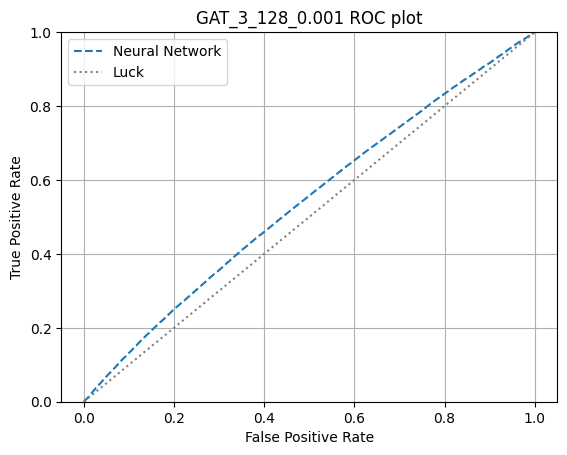

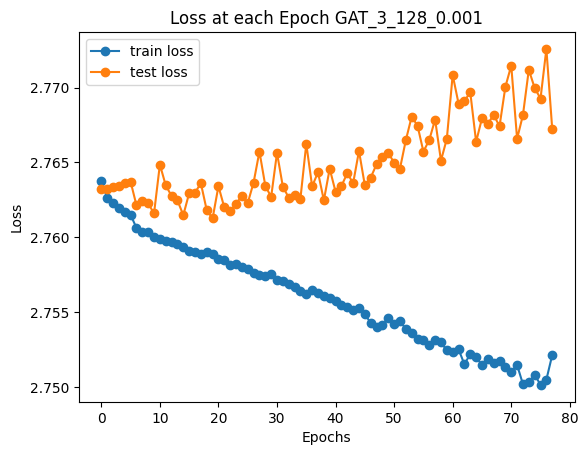

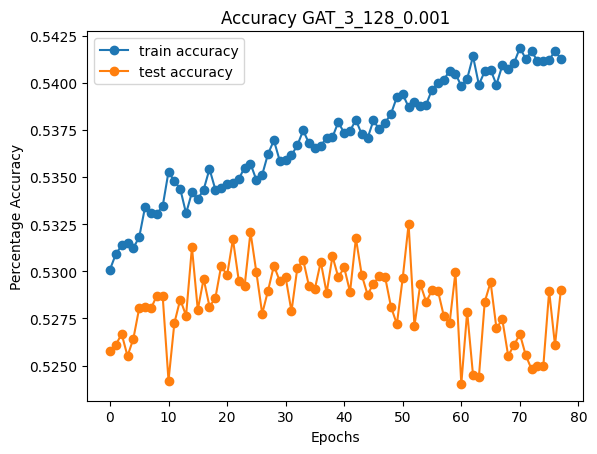

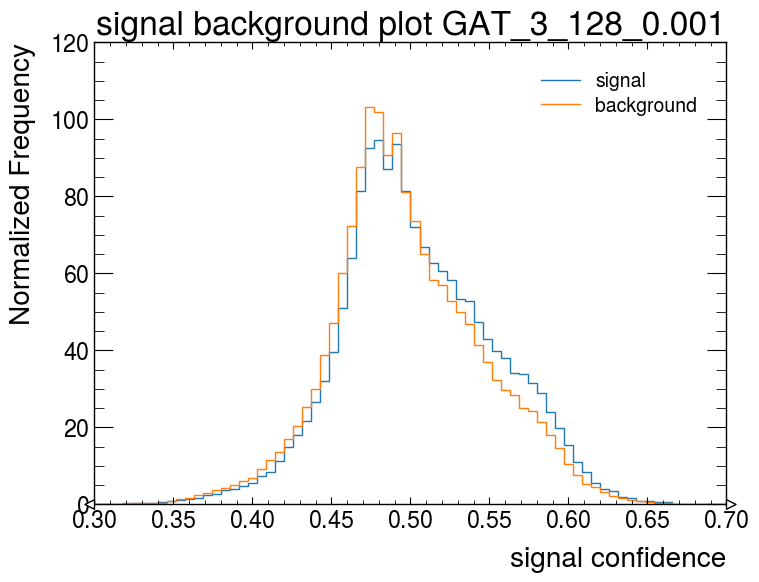

In [8]:
p = 'C:/Users/HP/OneDrive/Documents/internships/summer_internship/4 top odd even/GNN/on csf/models/'
costs_array = [] # final costs of test
accuracy_array = [] # final accuracy of test
min_cost_array = [] 
max_accuracy_array = []
average_stat_array = []
for training in file:
    title = training[0]
    model, layers, dims, _ = title.split('_')
    train_results = np.array(eval(training[1]))
    test_results = np.array(eval(training[2]))
    model = globals()[model](int(dims), int(layers))
    #print(f'models/model_{title}.pth')
    #model = torch.load(p+f'model_{title}.pth')
    model.load_state_dict(torch.load(p+f'model_{title}.pth'))
    model.eval()
    test_out = np.array([]) # first element is prediction, last element is what it should be
    test_y = np.array([])
    for data in tqdm(test_loader):
        x_transformed = torch.tensor(scaler.transform(data.x),dtype=torch.float32)
        out = model(x_transformed, data.edge_index, data.batch).cpu().detach().numpy()[:,0]
        test_out = np.hstack((test_out, out))
        test_y = np.hstack((test_y, np.array(data.y)))
    y_pred_test = (test_out>0.5)*1
    report = sklearn.metrics.classification_report(test_y, y_pred_test, target_names=["background", "signal"])
    print(report)
    b_prec, b_recall = report.split()[5:7]
    s_prec, s_recall = report.split()[10:12]
    #save_comparison(title, train_results[-1][1], test_results[-1][1], train_results[-1][0], test_results[-1][0], b_prec, b_recall, s_prec, s_recall, len(train_results))
    plot_signal_background(test_results, train_results, test_out, test_y, title, save = True)
    costs_array.append(test_results[-1][1])
    accuracy_array.append(test_results[-1][1])
    min_cost_array.append(np.min(test_results[:,1]))
    max_accuracy_array.append(np.max(test_results[:,0]))
    average_stat_array.append(np.mean([float(b_prec), float(b_recall), float(s_prec), float(s_recall)]))


In [9]:
costs_array = [] # final costs of test
accuracy_array = [] # final accuracy of test
min_cost_array = [] 
max_accuracy_array = []
average_stat_array = []
mask = np.array(costs)

NameError: name 'costs' is not defined

In [ ]:
mask = (np.argsort(costs_array)<2) & (np.argsort(-1*np.array(accuracy_array))<2) | (np.argsort(-1*np.array(accuracy_array))<2) |  (np.argsort(min_cost_array)<2) |  (np.argsort(-1*np.array(max_accuracy_array))<2) | (np.argsort(-1*np.array(average_stat_array))<2)

In [ ]:
len(mask)
np.sum(mask)

5

In [ ]:
best = np.array(file)[mask]
best[:,0]

array(['GRAPH_2_64_0.001', 'GRAPH_3_16_0.001', 'GRAPH_4_128_0.001',
       'GRAPH_5_16_0.001', 'GRAPH_5_64_0.001'], dtype='<U3318')